<a href="https://colab.research.google.com/github/deqiangwang123/3253-Machine-Learning/blob/main/W4_Homework_Solution_GooggleColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment for Mudule 4: Clustering

## Description

In this assignment you will study the electric demand (power) of clients in Portugal, during 2013 and 2014.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

In this guided exercise you will use clustering techniques to understand the typical behaviour during 2013-2014.

#### 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

#### 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm


## Data Preparation



In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

#Mount your Google drive so you can read them easilu
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

with fileinput.FileInput("/content/gdrive/My Drive/3253 UoT - Winter 2019/Shared_Drop_Box_UoT_3253_ML_Saeid_Abolfazli/Week 4/LD2011_2014.txt", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [ ]:
# Create dataframe
import pandas as pd
data = pd.read_csv("/content/gdrive/My Drive/3253 UoT - Winter 2019/Shared_Drop_Box_UoT_3253_ML_Saeid_Abolfazli/Week 4/LD2011_2014.txt", sep=";", index_col=0)

### Quick data inspection

In [ ]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.tail(2)

In [ ]:
data.shape

(74797, 370)

#### As can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74797 entries, 2011-01-01 00:15:00 to 2013-02-18 03:15:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(337), int64(33)
memory usage: 211.7+ MB


In [ ]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,74797.000000,74797.000000,74797.000000,74797.000000,74797.000000,74797.000000,74797.000000,74797.000000,74797.000000,74797.000000,...,74797.000000,74797.000000,74797.000000,74797.000000,74797.000000,74797.000000,74797.000000,74797.000000,74797.000000,74796.000000
mean,2.750745,14.253164,3.866393,54.048432,25.807038,101.529847,2.501778,135.815644,30.031098,29.522661,...,153.529138,27030.838135,1434.158921,2106.875033,51.775149,6.505942,308.031996,66.428883,451.351805,832.416533
std,5.204298,14.279240,15.010115,58.316949,27.370573,106.362322,4.656500,135.520776,33.345639,34.122784,...,199.681642,37414.924432,1862.535536,2627.823241,71.359963,9.559414,301.006394,78.670961,435.678998,3344.989562
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.269036,17.069701,1.737619,60.975610,26.829268,107.142857,1.130582,164.983165,29.720280,25.806452,...,51.391863,13900.000000,784.810127,1068.181818,15.645372,3.510825,396.839333,43.405676,664.956012,0.000000
75%,2.538071,27.027027,2.606429,91.463415,47.560976,187.500000,3.391747,259.259259,50.699301,50.537634,...,345.467523,44600.000000,2763.713080,3340.909091,109.517601,9.362200,590.869183,128.547579,846.041056,0.000000
max,48.223350,115.220484,151.172893,308.943089,120.731707,535.714286,35.613341,535.353535,157.342657,198.924731,...,849.393291,192800.000000,7350.210970,10000.000000,335.071708,57.343476,1130.816506,360.601002,1395.894428,22356.756757


### Plot the 2 days of 2012 for the first 2 clients

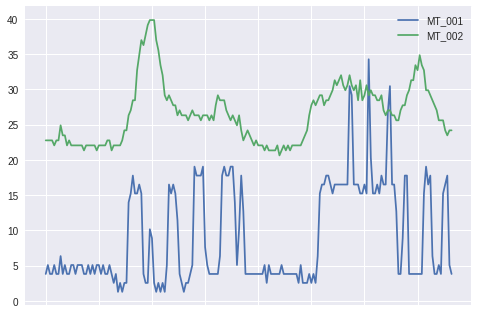

In [ ]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We quickly note that the main difference between the curves is the level (also seen on the means in df.describe()), so we know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day, rather than the overall level.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with lower number of clients having zero demand

In [ ]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [ ]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [ ]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [ ]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


## Getting average curves per client

In [ ]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [ ]:
data['hour'] = data.index.map(lambda x: x[11:])

In [ ]:
data.head(3)


,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


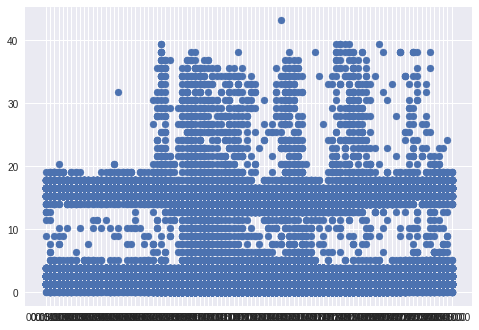

In [ ]:
plt.scatter(data['hour'],data['MT_001'])

### Getting average curves per client

In [ ]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 370)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [ ]:
average_curves_norm = average_curves/(average_curves.mean())

#### Plot the first 2 and last 2 clients

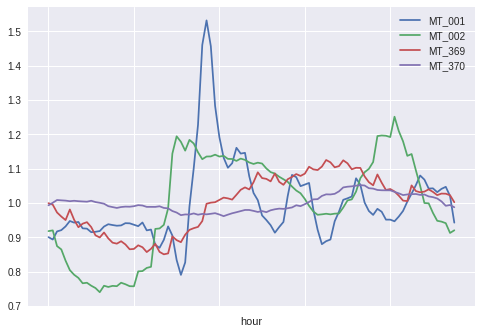

In [ ]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normizalied curves

In [ ]:
X = average_curves_norm.copy()
X = np.array(X.T) # put it on the right format

## Exercise 1:

a. Using the functions described in Module 2, determine what a convenient number of clusters based on _intertia_ and based on _silhouette_. Justify your choice

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the centroid of the cluster (make this curve thicker to distinguish it from the individual curves)
    
You can do 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

# Solution to Exercise 1

Copy from the notebook of Module 4 the needed pieces of code

In [ ]:
def getInertia(X,kmeans):
    ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
    return inertia

In [ ]:
inertias_1 = []
silhouette_avgs = []
max_K = 15
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

In [ ]:
inertias_1

[1707.229420029633,
 1175.5272754230882,
 865.9677208804297,
 657.6442657822121,
 580.005064735774,
 476.48468035158305,
 426.471281903853,
 391.54379279437853,
 367.88280301851745,
 349.56019291664916,
 333.92500350831295,
 315.9614911706731,
 304.0805254852021,
 291.1112938158416,
 286.4184035073186]

In [ ]:
silhouette_avgs

[0.37191838565388774,
 0.42244692513476645,
 0.4296355372224772,
 0.4226849822459896,
 0.4289726637003935,
 0.3963513816265128,
 0.27186604010600207,
 0.250216733060581,
 0.23753095057335363,
 0.19087159330654652,
 0.21201916396953233,
 0.18649877456476016,
 0.195799838543053,
 0.20665171047121292]

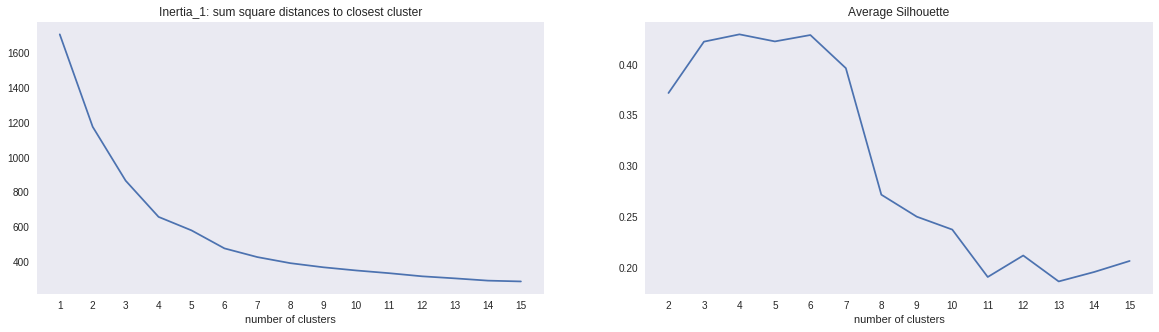

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,2,2)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

There are to evident elbows for k=4 and k=6. Those two values also maximize the silhouette plot. So both k=4 and k=6 are acceptable numbers of clusters.

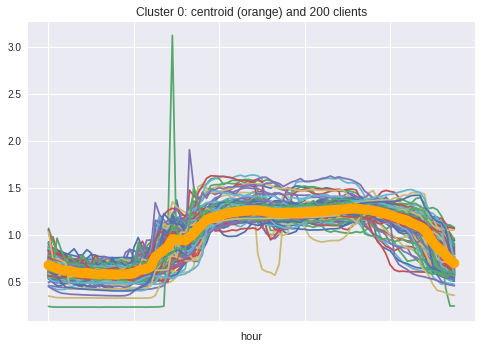

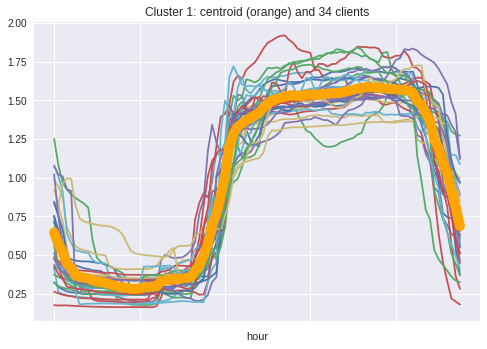

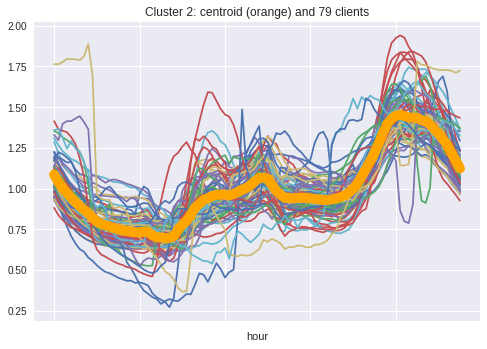

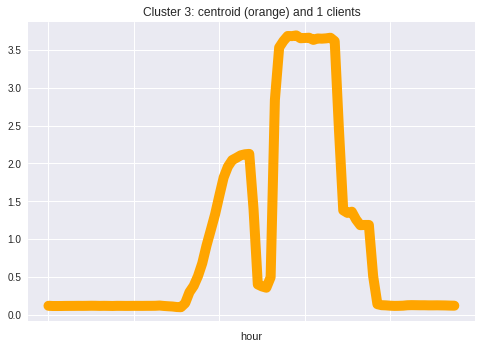

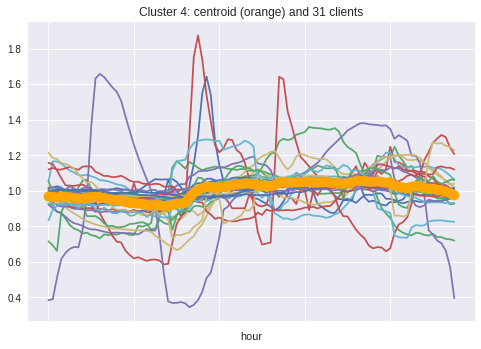

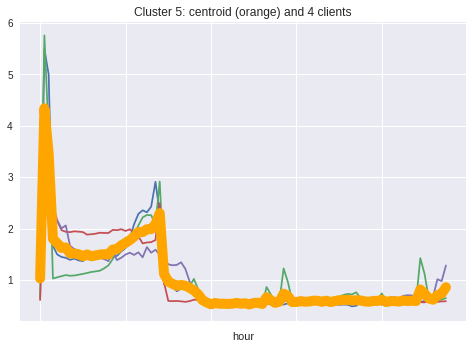

In [ ]:
K = 6 # the desired value
kmeans = KMeans(n_clusters=K, random_state=0).fit(X)  # re-train

# Plots
for c in range(K) :    
    average_curves_norm.T[kmeans.labels_==c].T.plot(legend=False)
    plt.plot(kmeans.cluster_centers_[c], linewidth=10, color='orange')
    plt.title("Cluster "+str(c)+": centroid (orange) and "+str(sum(kmeans.labels_==c))+" clients")
    plt.show()


## Exercises 2

In this exercise you work with the daily curves of 1 single client.

First you create a list of arrays, each array containing a normalized curve for a day. The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value for k-means. 

b. What are the clusters that you obtained represent?

In [ ]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 

#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b)

In [ ]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

#### The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for pard (b)

In [ ]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

[2, 3]

# Solution to Exercise 2

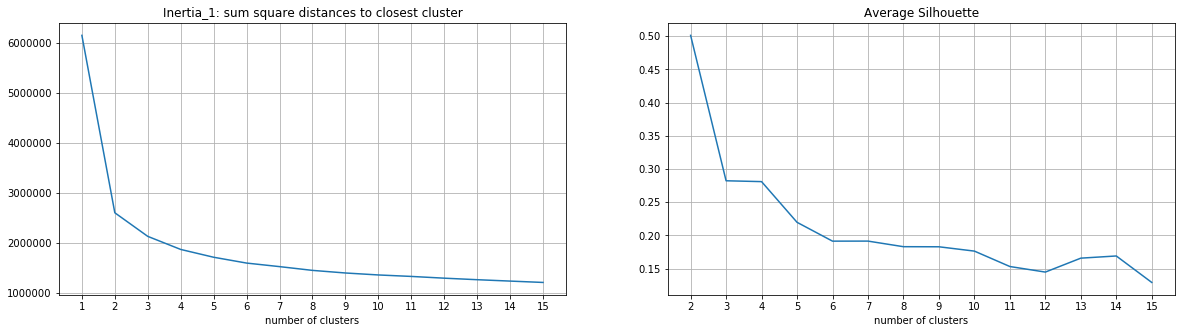

In [ ]:
inertias_1 = []
silhouette_avgs = []
max_K = 15
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,2,2)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

#### The optimal value is k=2

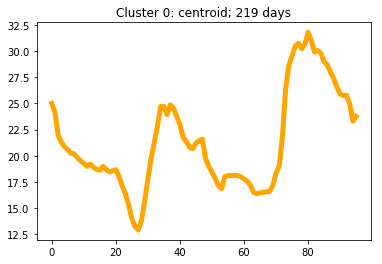

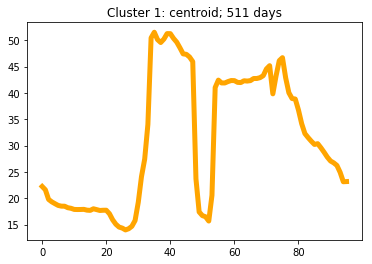

In [ ]:
K = 2 # the desired value
kmeans = KMeans(n_clusters=K, random_state=0).fit(X)  # re-train

# Plots
for c in range(K):
    plt.plot(kmeans.cluster_centers_[c], linewidth=5, color='orange')
    plt.title("Cluster "+str(c)+": centroid; "+str(sum(kmeans.labels_==c))+" days")
    plt.show()

#### The number of days in each cluster give ratios 5/7 and 2/7, so cluster 0 _may be_ weekends, and cluster 1 weekdays.

#### Since the arrays in X are in chronological order, we can see the patters in the labels, which seem very regular.

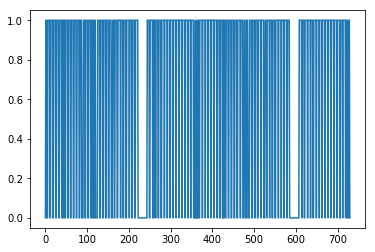

In [ ]:
plt.plot(kmeans.labels_)
plt.show()

#### Finally, since we have a list of days of the year in the variable _daysyear_, we can see which days correspond to cluster 1

In [ ]:
from itertools import compress
list(compress(daysyear, kmeans.labels_==0))

['tue-2013-01-01',
 'sat-2013-01-05',
 'sun-2013-01-06',
 'sat-2013-01-12',
 'sun-2013-01-13',
 'sat-2013-01-19',
 'sun-2013-01-20',
 'sat-2013-01-26',
 'sun-2013-01-27',
 'sat-2013-02-02',
 'sun-2013-02-03',
 'sat-2013-02-09',
 'sun-2013-02-10',
 'tue-2013-02-12',
 'sat-2013-02-16',
 'sun-2013-02-17',
 'sat-2013-02-23',
 'sun-2013-02-24',
 'sat-2013-03-02',
 'sun-2013-03-03',
 'sat-2013-03-09',
 'sun-2013-03-10',
 'sat-2013-03-16',
 'sun-2013-03-17',
 'sat-2013-03-23',
 'sun-2013-03-24',
 'fri-2013-03-29',
 'sat-2013-03-30',
 'sun-2013-03-31',
 'mon-2013-04-01',
 'sat-2013-04-06',
 'sun-2013-04-07',
 'sat-2013-04-13',
 'sun-2013-04-14',
 'sat-2013-04-20',
 'sun-2013-04-21',
 'thu-2013-04-25',
 'sat-2013-04-27',
 'sun-2013-04-28',
 'wed-2013-05-01',
 'thu-2013-05-02',
 'fri-2013-05-03',
 'sat-2013-05-04',
 'sun-2013-05-05',
 'sat-2013-05-11',
 'sun-2013-05-12',
 'sat-2013-05-18',
 'sun-2013-05-19',
 'sat-2013-05-25',
 'sun-2013-05-26',
 'sat-2013-06-01',
 'sun-2013-06-02',
 'sat-2013-0

#### Many of these days seem to be weekends, although other week-days may be holidays. We now remove the date, just keeping the name of the day, and then see the counts per day in cluster 0 and cluster 1:

In [ ]:
weekdays = []
for i in range(delta.days + 1):
    weekdays.extend([D[(d1 + timedelta(days=i)).weekday()]])

weekdays_CL0 = list(compress(weekdays, kmeans.labels_==0))
weekdays_CL1 = list(compress(weekdays, kmeans.labels_==1))

In [ ]:
from collections import Counter

print(Counter(weekdays_CL0))
print(Counter(weekdays_CL1))

Counter({'sun': 104, 'sat': 58, 'tue': 12, 'mon': 12, 'wed': 12, 'fri': 11, 'thu': 10})
Counter({'thu': 94, 'wed': 93, 'fri': 93, 'tue': 93, 'mon': 92, 'sat': 46})


The distribution over the days of the week for each cluster shows that cluster 0 is uniformly distributed over week-days, with around 5% of points (curves) on each day, and then 26% on Saturdays, and 47% on Sunday

In [ ]:
counter_CL0 = Counter(weekdays_CL0)
counter_CL1 = Counter(weekdays_CL1)

for day in ['mon','tue','wed','thu','fri','sat','sun']:
    if day in counter_CL0.keys():
        print(day, counter_CL0[day]/sum(counter_CL0.values()))

mon 0.0547945205479452
tue 0.0547945205479452
wed 0.0547945205479452
thu 0.045662100456621
fri 0.0502283105022831
sat 0.2648401826484018
sun 0.4748858447488584


For cluster 0 instead, the weekdays have around 18% of the cluster, while Saturday 9%, and Sunday 0%

In [ ]:
for day in ['mon','tue','wed','thu','fri','sat','sun']:
    if day in counter_CL1.keys():
        print(day, counter_CL1[day]/sum(counter_CL1.values()))

mon 0.18003913894324852
tue 0.18199608610567514
wed 0.18199608610567514
thu 0.18395303326810175
fri 0.18199608610567514
sat 0.09001956947162426
